In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT DATA

In [ ]:
ephys_data = loadmat("singleunit.mat")

BASIC DESCRIPTION OF DATA

In [ ]:
type(ephys_data)

dict

In [ ]:
ephys_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'singleunit'])

In [ ]:
ephys_data.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 16 10:20:29 2020'), ('__version__', '1.0'), ('__globals__', []), ('singleunit', array([[(array(['PN'], dtype='<U2'), array([[10000]], dtype=uint16), array(['seconds'], dtype='<U7'), array([[0]], dtype=uint8), array([[120.5248]]), array([[0.12817383],
       [0.08239746],
       [0.11901855],
       ...,
       [0.06713867],
       [0.07324219],
       [0.07629394]]), array([[-0.0088501 ],
       [-0.00823975],
       [-0.0088501 ],
       ...,
       [-0.0088501 ],
       [-0.00976562],
       [-0.0088501 ]])),
        (array(['PN'], dtype='<U2'), array([[10000]], dtype=uint16), array(['seconds'], dtype='<U7'), array([[0]], dtype=uint8), array([[105]], dtype=uint8), array([[0.03356934],
       [0.03051758],
       [0.09155273],
       ...,
       [0.08850098],
       [0.08544922],
       [0.08850098]]), array([[-0.00823975],
       [-0.0088501 ],
       [-0.0088501 ],
       ...,
       [-0.0091552

In [ ]:
dat = ephys_data['singleunit']

In [ ]:
type(dat), dat.shape

(numpy.ndarray, (1, 33))

In [ ]:
# When we use dat[x][y], x is always 0 (not sure why, maybe 1st dimension?), and y is the neuron. Here, this is neuron 1:
type(dat[0][0]), dat[0][0].shape

(numpy.void, ())

In [ ]:
print(dat[0][0])

(array(['PN'], dtype='<U2'), array([[10000]], dtype=uint16), array(['seconds'], dtype='<U7'), array([[0]], dtype=uint8), array([[120.5248]]), array([[0.12817383],
       [0.08239746],
       [0.11901855],
       ...,
       [0.06713867],
       [0.07324219],
       [0.07629394]]), array([[-0.0088501 ],
       [-0.00823975],
       [-0.0088501 ],
       ...,
       [-0.0088501 ],
       [-0.00976562],
       [-0.0088501 ]]))


In [ ]:
dat[0][0]['NType']

array(['PN'], dtype='<U2')

In [ ]:
dat[0][0]['recording'].shape

(1205248, 1)

VISUALIZING SAMPLES OF DATA

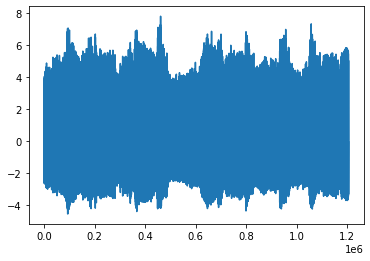

In [ ]:
# 'recording' has the individual spiking patterns for each of the 33 neurons
# dat[0][0]['recording'] is for neuron 1, shows all data for neuron 1

plt.plot(dat[0][0]['recording'])

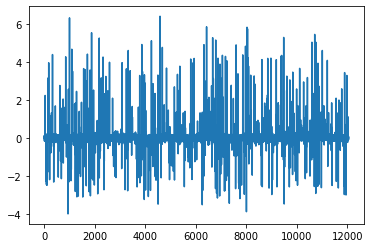

In [ ]:
# the individual spiking pattern for neuron (zoomed in by going by 100s)

plt.plot(dat[0][0]['recording'][0:-1:100])

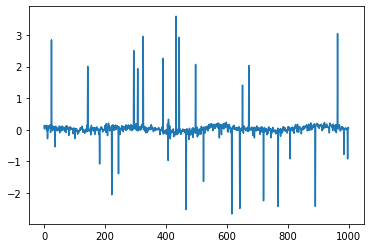

In [ ]:
# the individual spiking pattern for neuron 1 (first 10,000 timepoints)

plt.plot(dat[0][0]['recording'][0:10000:10])

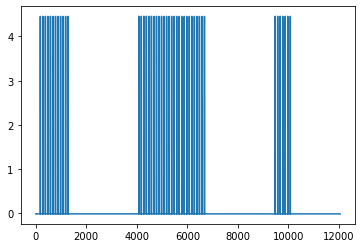

In [ ]:
# 'TTLch' shows the optogenetic stimulation patterns for all 33 neurons
# dat[0][0]['TTLch'] is for neuron 1

plt.plot(dat[0][0]['TTLch'][0:-1:100])

In [ ]:
dat[0][0]['TTLch'][17974]

array([4.45739746])

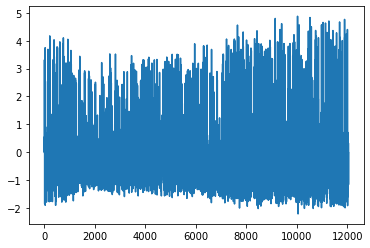

In [ ]:
# dat[0][0]['recording'] is for neuron 26

plt.plot(dat[0][25]['recording'][0:-1:100])

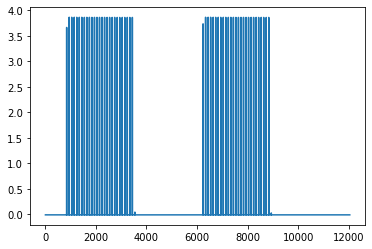

In [ ]:
# dat[0][25]['TTLch'] is for neuron 26 - can see minimum is 3.5 units, so this will be our threshold

plt.plot(dat[0][25]['TTLch'][0:-1:100])


DATA ANALYSIS: DETERMINING FIRING RATES 

In [ ]:
# GOALS OF THE PROJECT
  # - find the avg firing rates for each neuron during stimulation vs. no stim
  # - compare the effects of the optogenetic stimulation on firing rates for
  #   different types of neuron, either PN or DCN 

In [ ]:
## create empty lists for the four variables of interest

# avg firing rates for Purkinje Neurons during optogenetic stimulation
PN_firing_stim = []
# avg firing rates for Purkinje Neurons without optogenetic stimulation
PN_firing_no_stim = [] 

# avg firing rates for Deep Cerebellar Nuclei neurons during optogenetic stimulation
DCN_firing_stim = [] 
# avg firing rates for Deep Cerebellar Nuclei neurons without optogenetic stimulation
DCN_firing_no_stim = [] 

In [ ]:
# sorting neurons by type
# first 20 are purkinje neurons, last 13 are DCN neurons
for i in range(0, 33):
  print(i + 1, dat[0][i]['NType'])

1 ['PN']
2 ['PN']
3 ['PN']
4 ['PN']
5 ['PN']
6 ['PN']
7 ['PN']
8 ['PN']
9 ['PN']
10 ['PN']
11 ['PN']
12 ['PN']
13 ['PN']
14 ['PN']
15 ['PN']
16 ['PN']
17 ['PN']
18 ['PN']
19 ['PN']
20 ['PN']
21 ['DCN']
22 ['DCN']
23 ['DCN']
24 ['DCN']
25 ['DCN']
26 ['DCN']
27 ['DCN']
28 ['DCN']
29 ['DCN']
30 ['DCN']
31 ['DCN']
32 ['DCN']
33 ['DCN']


In [ ]:
# Using loops to find when neurons fire, if they are "significant" fires, their averages, etc.

# neurons 1 to 20 are Purkinje Neurons

for i in range(0, 20):

  # create empty lists for times when optogenetic stimulation is on & not on 
  # these lists get reset for each new neuron
  TTLch_stim = []
  TTLch_no_stim = []

  # create empty lists for electrical recording values during & without stimulation
  # these lists get reset for each new neuron
  recording_stim = []
  recording_no_stim = []
    
  # go through all 'TTLch' values for the neuron
  for j in range(len(dat[0][i]['TTLch'])):

    # for all times that the optogenetic stimulation is ON ('TTLch' val > 3.5),
    # store the time index and 'recording' value at that time 
    if dat[0][i]['TTLch'][j] > 3.5:
      TTLch_stim.append(j)
      recording_stim.append(dat[0][i]['recording'][j])

    # for all times that optogenetic stimulation is NOT ON ('TTLch' val < 3.5),
    # store the time index and 'recording' value at that time 
    else:
      TTLch_no_stim.append(j)
      recording_no_stim.append(dat[0][i]['recording'][j])

  # find the average & standard deviation for the stored 'recording' values
  avg_recording_stim = np.mean(recording_stim)
  std_recording_stim = np.std(recording_stim)
  avg_recording_no_stim = np.mean(recording_no_stim)
  std_recording_no_stim = np.std(recording_no_stim)

  # considered neuron firing if the 'recording' val is more than two 
  # standard deviations below average
  count_stim = 0
  count_no_stim = 0

  for k in range(len(recording_stim)): # find spike count for stim  
    if recording_stim[k] < (avg_recording_stim - (2 * std_recording_stim)):
      count_stim += 1
      
  for l in range(len(recording_no_stim)): # find spike count for no stim
    if recording_no_stim[l] < (avg_recording_no_stim - (2 * std_recording_no_stim)):
      count_no_stim += 1
    
  # calculate avg firing for stim & no stim and store in proper list
  avg_firing_stim = count_stim / len(recording_stim)
  PN_firing_stim.append(avg_firing_stim)
  avg_firing_no_stim = count_no_stim / len(recording_no_stim)
  PN_firing_no_stim.append(avg_firing_no_stim)


In [ ]:
# Print the data from the previous chunk: should have 20 entries (20 neurons)
print(PN_firing_stim)
print(PN_firing_no_stim)
print(len(PN_firing_no_stim))
print(len(PN_firing_stim))

[0.027677496991576414, 0.03115522801289899, 0.02846832397754611, 0.029835802963556268, 0.033342673017652, 0.03303056978233035, 0.028760396833350035, 0.0315877972615902, 0.031269380814244276, 0.028406703982139785, 0.026268297573691597, 0.028960817717206135, 0.030265422955282437, 0.029048714614384314, 0.025821990701842826, 0.0530445185063675, 0.043613956466069144, 0.03474640726952484, 0.02845691382765531, 0.026474127557160047]
[0.013651186157688905, 0.0104629914331211, 0.012851527063804052, 0.013319812834314156, 0.01326586677712489, 0.012438127727010785, 0.012804715098338165, 0.012460046792101373, 0.012467826499367347, 0.009813436479114979, 0.011980706129748806, 0.012890343146997706, 0.012265307412010026, 0.010660680179594612, 0.008778224544678128, 0.013634347733510263, 0.013627377992367296, 0.013555368759040069, 0.013553950889212489, 0.01239088776527821]
20
20


In [ ]:
#len(recording_stim)

4986

In [ ]:
#avg_recording_stim

-0.04491170180472183

In [ ]:
#count_stim

132

In [ ]:
# Same thing for DCN neurons

# neurons 21 to 33 are DCN Neurons

for i in range(20, 33):
  # create empty lists for times when optogenetic stimulation is on & not on 
  # these lists get reset for each new neuron
  TTLch_stim = []
  TTLch_no_stim = []

  # create empty lists for electrical recording values during & without stimulation
  # these lists get reset for each new neuron
  recording_stim = []
  recording_no_stim = []
    
  # go through all 'TTLch' values for the neuron
  for j in range(len(dat[0][i]['TTLch'])):

    # for all times that the optogenetic stimulation is ON ('TTLch' val > 3.5),
    # store the time index and 'recording' value at that time 
    if dat[0][i]['TTLch'][j] > 3.5:
      TTLch_stim.append(j)
      recording_stim.append(dat[0][i]['recording'][j])

    # for all times that optogenetic stimulation is NOT ON ('TTLch' val < 3.5),
    # store the time index and 'recording' value at that time 
    else:
      TTLch_no_stim.append(j)
      recording_no_stim.append(dat[0][i]['recording'][j])

  # find the average & standard deviation for the stored 'recording' values
  avg_recording_stim = np.mean(recording_stim)
  std_recording_stim = np.std(recording_stim)
  avg_recording_no_stim = np.mean(recording_no_stim)
  std_recording_no_stim = np.std(recording_no_stim)

  # considered neuron firing if the 'recording' val is more than two 
  # standard deviations below average
  count_stim = 0
  count_no_stim = 0

  for k in range(len(recording_stim)): # find spike count for stim  
    if recording_stim[k] < (avg_recording_stim - (2 * std_recording_stim)):
      count_stim += 1
      
  for l in range(len(recording_no_stim)): # find spike count for no stim
    if recording_no_stim[l] < (avg_recording_no_stim - (2 * std_recording_no_stim)):
      count_no_stim += 1
    
  # calculate avg firing for stim & no stim and store in proper list
  avg_firing_stim = count_stim / len(recording_stim)
  DCN_firing_stim.append(avg_firing_stim)
  avg_firing_no_stim = count_no_stim / len(recording_no_stim)
  DCN_firing_no_stim.append(avg_firing_no_stim)


In [ ]:
# Print the data from the previous chunk: should have 13 entries (13 neurons)
print(DCN_firing_stim)
print(DCN_firing_no_stim)
print(len(DCN_firing_no_stim))
print(len(DCN_firing_stim))

[0.02891566265060241, 0.033891507069086536, 0.01990069672459358, 0.00850323122786659, 0.0192650089023146, 0.031921300943585626, 0.03358732705033086, 0.022385071279833413, 0.014264992747461612, 0.0020814153624464636, 0.008020854220974533, 0.0036075759094097606, 0.0014004061177741545]
[0.025952777064669818, 0.03605068742403341, 0.02685202608661747, 0.02065024534318203, 0.022433421983233018, 0.02809490270930315, 0.029613904736632612, 0.03015452048900676, 0.02334771049592687, 0.013983871999518343, 0.014693280782576507, 0.014149285763198311, 0.01758649945166611]
13
13


DISPLAYING THE RESULTS

In [ ]:
# independent t-test 
print(stats.ttest_ind(PN_firing_stim, PN_firing_no_stim)) 
print(stats.ttest_ind(DCN_firing_stim, DCN_firing_no_stim))

# group means
print('\nmean firing rate for all purkinje neurons with stim:   ', np.mean(PN_firing_stim))
print('mean firing rate for all purkinje neurons without stim:', np.mean(PN_firing_no_stim))
print('\nmean firing rate for all DCN neurons with stim:   ', np.mean(DCN_firing_stim))
print('mean firing rate for all DCN neurons without stim:', np.mean(DCN_firing_no_stim))

Ttest_indResult(statistic=13.086056261255763, pvalue=1.1851635981935246e-15)
Ttest_indResult(statistic=-1.5036854751196223, pvalue=0.14570877340200009)

mean firing rate for all purkinje neurons with stim:    0.03151177704130343
mean firing rate for all purkinje neurons without stim: 0.012343636570721168

mean firing rate for all DCN neurons with stim:    0.017518850015867702
mean firing rate for all DCN neurons without stim: 0.023351010333043414


In [ ]:
data_to_plot = [PN_firing_stim, PN_firing_no_stim, DCN_firing_stim, DCN_firing_no_stim]

Text(1.5, 0.06, '***')

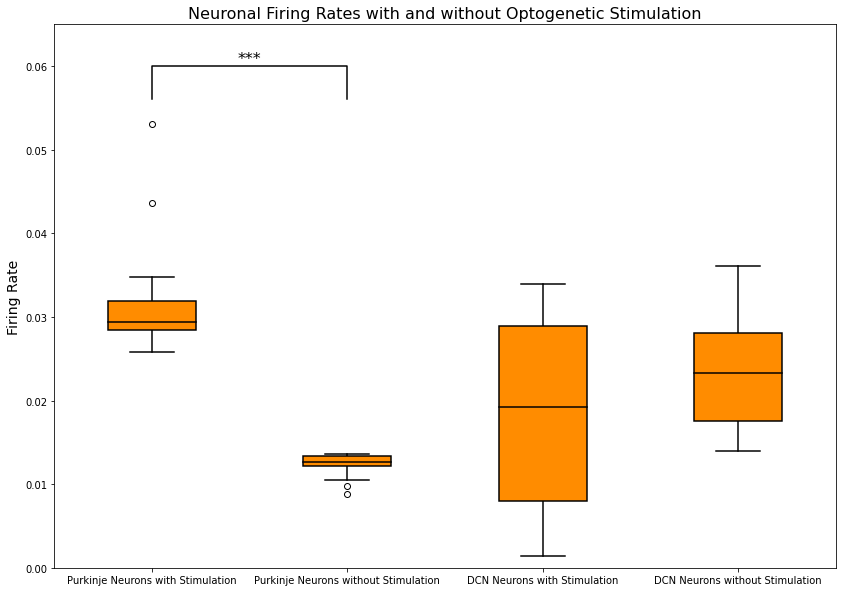

In [ ]:
# Create a figure 
fig = plt.figure(1, figsize = (14, 10))
ax = fig.add_subplot(111)

# Create the boxplot & set colors
bp = ax.boxplot(data_to_plot, patch_artist=True,
                boxprops=dict(facecolor = 'darkorange', color = 'k', lw = 1.5),
                capprops=dict(lw = 1.5), whiskerprops=dict(lw = 1.5),
                medianprops=dict(color = 'k', lw = 1.5))

# Add horizontal axis labels
plt.xticks([1, 2, 3, 4], ['Purkinje Neurons with Stimulation', 'Purkinje Neurons without Stimulation', 
                          'DCN Neurons with Stimulation', 'DCN Neurons without Stimulation'])
# Set y-axis limits
plt.ylim(0, 0.065)

# Add title and y-axis labels
ax.set_title('Neuronal Firing Rates with and without Optogenetic Stimulation', fontsize = 16)
ax.set_ylabel('Firing Rate', fontsize = 14)

# Add significance marks for PN stim vs. no stim
plt.plot([1, 1, 2, 2], [0.056, 0.06, 0.06, 0.056], lw = 1.5, c = 'k')
plt.text(1.5, .06, "***", ha = 'center', va = 'bottom', color = 'k', fontsize = 16)
